In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

import lightgbm as lgb

from sklearn import ensemble, gaussian_process, linear_model
from sklearn import naive_bayes, neighbors, svm, tree, discriminant_analysis
from sklearn import model_selection

from xgboost import XGBClassifier

/Users/Alex/Programmes/Anaconda/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


### Make submission

In [2]:
# Submission function
def make_submission(ytest, filename="Titanic Prediction.csv"):
    submission = pd.DataFrame({'PassengerId':xtest_fe['PassengerId'],'Survived':ytest})
    submission.to_csv(filename,index=False)
    print('Saved file: ' + filename)
    
submissions = {}

### Train / Test dataset

In [3]:
xtest_fe = pd.read_csv('xtest_fe')
xtrain_fe = pd.read_csv('xtrain_fe')
labels = pd.read_csv('train.csv').Survived

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(xtrain_fe, labels, test_size=0.25, random_state=42)

In [5]:
print(xtrain_fe.shape)
print(labels.shape)

(891, 69)
(891,)


# Dimension Reduction

## Plot feature importance

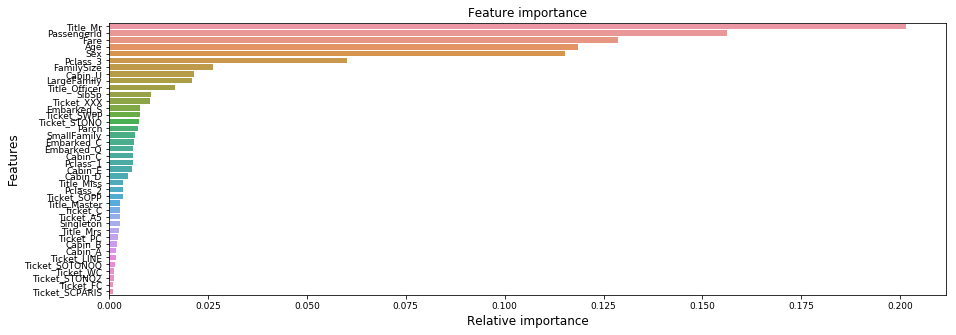

In [6]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(xtrain_fe, labels)

plt.figure(figsize=(15,5))

name = "Feature Importance - Titanic"

indices = np.argsort(rf.feature_importances_)[::-1][:40]
g = sns.barplot(y=xtrain_fe.columns[indices][:40],x = rf.feature_importances_[indices][:40] , orient='h')
g.set_xlabel("Relative importance",fontsize=12)
g.set_ylabel("Features",fontsize=12)

g.tick_params(labelsize=9)
g.set_title("Feature importance")
plt.savefig('images/importance.png')

plt.show()

## LDA - Linear Discriminant Analysis

In [15]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()

lda.fit(xtrain_fe, labels)

lda.explained_variance_ratio_

/Users/Alex/Programmes/Anaconda/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


array([1.])

## PCA - Principal Component Analysis

In [21]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

xtrain_pca = pca.fit_transform(xtrain_fe)
xtest_pca = pca.transform(xtest_fe)

print(pca.explained_variance_ratio_)  
print(pca.singular_values_)

[0.96138607 0.03589043]
[7677.6466252  1483.43507639]


# Random Forest

- 500 estimators RFClassifier : **0.73205**
- Optimized RandomSearch hyperparameters : **0.77033**

In [108]:
# Filtering string columns for random forest

# Create Classifier
rf = RandomForestClassifier(n_estimators=1000)

# Fit and predict
rf.fit(xtrain_fe, np.ravel(labels))
ytest_rf = rf.predict(xtest_fe)

# Make Submission
make_submission(ytest_rf, "Titanic Predictions RF500 - FE.csv")

Saved file: Titanic Predictions RF500 - FE.csv


In [14]:
submissions["Random Forest Quick"] = 0.73205
submissions["Random Forest Feat. Eng."] = 0.74641

## RandomizedSearch

In [17]:
# Classifier
rf2 = RandomForestClassifier(n_jobs=-1)

# Create hyperparameter options
rf_max_depth=[2, 3, 5, 7, 10, 20, 35, 60, 100]
rf_n_estimators=[100, 200, 500, 1000, 1200]
rf_min_samples_split=[2, 4, 6, 10]
rf_criterion=['gini', 'entropy']

hyperparameters = dict(
    max_depth=rf_max_depth,
    min_samples_split=rf_min_samples_split,
    n_estimators=rf_n_estimators,
    criterion=rf_criterion)

# Create randomized grid search
clf = RandomizedSearchCV(rf2, hyperparameters, random_state=1, n_iter=300, cv=5, verbose=10, n_jobs=-1)

# Fit randomized search
best_model = clf.fit(xtrain_fe, labels)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   37.1s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   53.6s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  1

In [18]:
best_model.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [19]:
# Create Classifier
rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

# Fit and predict
rf.fit(xtrain_fe, labels)
ytest_rf = rf.predict(xtest_fe)

# Make Submission
make_submission(ytest_rf, "Titanic Predictions RF-RandomSearch.csv")

Saved file: Titanic Predictions RF-RandomSearch.csv


In [120]:
scores = cross_val_score(rf, xtrain_fe, labels, cv=5)
scores.mean()

0.8081392317930398

In [ ]:
submissions["Random Forest tuned"] = 0.78947

# XGBoost

In [28]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

# Classifier
xgb = XGBClassifier(n_jobs=-1, silent=False)

# Create hyperparameter options
xgb_max_depth=[3, 5, 10, 20, 50]             # Usual values between 3-10
xgb_learning_rate=[0.01, 0.1, 0.5, 1, 2]    # Makes the model more robust by shrinking the weights on each step
xgb_n_estimators=[100, 200, 500, 1000, 1200]
xgb_booster=['gbtree', 'gblinear', 'dart']
xgb_reg_lambda=[1, 2]                       # L2 used to reduce overfitting

hyperparameters = dict(
    max_depth = xgb_max_depth, 
    learning_rate = xgb_learning_rate,
    n_estimators = xgb_n_estimators,
    booster=xgb_booster,
    reg_lambda=xgb_reg_lambda)

# Create randomized grid search
rscv = RandomizedSearchCV(xgb, hyperparameters, random_state=1, n_iter=100, cv=3, verbose=10, n_jobs=-1)
# Fit randomized search
best_model = rscv.fit(xtrain_fe, labels)

# View Hyperparameter Values Of Best Model
print('Best max_depth:', best_model.best_estimator_.get_params()['max_depth'])
print('Best learning_rate:', best_model.best_estimator_.get_params()['learning_rate'])
print('Best n_estimators:', best_model.best_estimator_.get_params()['n_estimators'])

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   49.1s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  4

[10:04:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[10:04:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[10:04:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[10:04:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[10:04:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[10:04:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[10:04:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[10:04:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[10:04:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_

[10:04:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[10:04:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[10:04:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[10:04:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[10:04:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[10:04:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[10:04:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[10:04:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[10:04:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_

In [28]:
xgbc = XGBClassifier(
    n_jobs=-1, 
    max_depth=1, 
    learning_rate=0.001, 
    n_estimators=3000)

xgbc.fit(xtrain_fe, labels)

ytest_xgb = xgbc.predict(xtest_fe)

make_submission(ytest_xgb, "submissions/Titanic Predictions XGB.csv")

Saved file: submissions/Titanic Predictions XGB.csv


## XGBoost with PCA

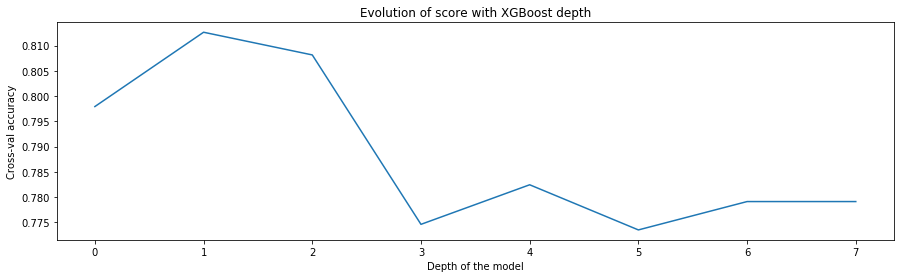

In [30]:
accuracy = []

for depth in [1, 2, 3, 5, 7, 10, 15, 20]:
    
    xgbc = XGBClassifier(
        n_jobs=-1, max_depth=depth, learning_rate=0.001, n_estimators=3000)

    xgbc.fit(X_train, y_train)
    y_test_xgb = xgbc.predict(X_test)
    accuracy.append(cross_val_score(xgbc, xtrain_fe, labels, cv=5).mean())
    
plt.figure(figsize=(15, 4))
plt.title('Evolution of score with XGBoost depth')
plt.xlabel('Depth of the model')
plt.ylabel('Cross-val accuracy')
plt.plot(accuracy)
plt.show()

In [10]:
xgbc = XGBClassifier(
    n_jobs=-1, 
    max_depth=3, 
    learning_rate=0.001, 
    n_estimators=6000)

xgbc.fit(xtrain_fe, labels)

ytest_xgb = xgbc.predict(xtest_fe)

make_submission(ytest_xgb, "submissions/Titanic Predictions XGB.csv")

Saved file: submissions/Titanic Predictions XGB.csv


In [20]:
submissions["XGBoost depth=1 LR=0.001 n_est=3K"] = 0.77990
submissions["XGBoost depth=2 LR=0.001 n_est=3K"] = 0.76076
submissions["XGBoost depth=3 LR=0.001 n_est=3K"] = 0.78947
submissions["XGBoost depth=4 LR=0.001 n_est=3K"] = 0.77990
submissions["XGBoost depth=5 LR=0.001 n_est=3K"] = 0.77511
submissions["XGBoost depth=10 LR=0.001 n_est=3K"] = 0.75119


# LGBM

In [41]:
lgb_estimator = lgb.LGBMClassifier(
    boosting_type='gbdt',  
    objective='binary', 
    n_estimators=10000, 
    learning_rate=0.001, 
    metric='binary_logloss',
    n_jobs=-1)

lgb_estimator.fit(xtrain_fe, labels)
ytest_lgb = lgb_estimator.predict(xtest_fe)

make_submission(ytest_lgb, "Titanic Predictions LGB.csv")

Saved file: Titanic Predictions LGB.csv


In [44]:
submissions["LGBM raw"] = 0.77033

In [135]:
# Classifier
lgb_estimator = lgb.LGBMClassifier(
    boosting_type='gbdt',  
    objective='binary', 
    n_estimators=100, 
    learning_rate=0.1, 
    metric='binary_logloss',
    n_jobs=-1)

# Create hyperparameter options
hyperparameters = dict(
    num_leaves = [31, 60, 128, 160, 250], 
    reg_alpha = [0.1, 0.5],
    n_estimators = [100, 200, 500, 1000, 2000, 5000],
    lambda_l1 = [0, 1, 1.5],
    lambda_l2 = [0, 1],
    max_depth = [7])

# Create randomized grid search
rscv = RandomizedSearchCV(
    lgb_estimator, hyperparameters,
    n_iter=500, cv=3, 
    verbose=10, n_jobs=-1)

# Fit randomized search
best_model = rscv.fit(xtrain_fe, labels)

# View Hyperparameter Values Of Best Model
print('Best num_leaves:', best_model.best_estimator_.get_params()['num_leaves'])
print('Best reg_alpha:', best_model.best_estimator_.get_params()['reg_alpha'])
print('Best lambda_l1:', best_model.best_estimator_.get_params()['lambda_l1'])
print('Best lambda_l2:', best_model.best_estimator_.get_params()['lambda_l2'])

Fitting 3 folds for each of 360 candidates, totalling 1080 fits


/Users/Alex/Programmes/Anaconda/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 360 is smaller than n_iter=500. Running 360 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


KeyboardInterrupt: 

In [46]:
lgb_estimator = lgb.LGBMClassifier(
    boosting_type='gbdt',  
    objective='binary', 
    n_estimators=10000, 
    learning_rate=0.001, 
    num_leaves = 31,
    metric='binary_logloss',
    reg_alpha = 0.1,
    lambda_l1 = 1.5,
    lambda_l2 = 1,
    n_jobs=-1)

lgb_estimator.fit(xtrain_fe, labels)
ytest_lgb = lgb_estimator.predict(xtest_fe)

make_submission(ytest_lgb, "Titanic Predictions LGB tuned.csv")

Saved file: Titanic Predictions LGB tuned.csv


In [47]:
submissions["LGBM tuned"] = 0.76555

In [50]:
submissions

{'LGBM raw': 0.77033,
 'LGBM tuned': 0.76555,
 'Random Forest Feat. Eng.': 0.74641,
 'Random Forest Quick': 0.73205,
 'XGBoost depth=10 LR=0.001 n_est=3K': 0.75119,
 'XGBoost depth=3 LR=0.001 n_est=3K': 0.78947}

# MLA Ensemble model

In [9]:
#Machine Learning Algorithm (MLA) Selection and Initialization
MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),
    #Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),
    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    #SVM
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    svm.LinearSVC(),
    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),
    #xgboost
    XGBClassifier()    
]

#split dataset in cross-validation with this splitter class: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html#sklearn.model_selection.ShuffleSplit
#note: this is an alternative to train_test_split
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 ) # run model 10x with 60/30 split intentionally leaving out 10%

#create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD' ,'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

#create table to compare MLA predictions
MLA_predict = labels

#index through MLA and save performance to table
row_index = 0
for alg in MLA:

    #set name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    #score model with cross validation:
    cv_results = model_selection.cross_val_score(alg, xtrain_fe[:891], labels[:891], cv  = cv_split)
    
    #MLA_compare.loc[row_index, 'MLA Time'] = cv_results.mean()
    #MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results.mean()   
    #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
    #MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3   #let's know the worst that can happen!
    

    #save MLA predictions - see section 6 for usage
    alg.fit(xtrain_fe, labels)
    MLA_predict[MLA_name] = alg.predict(xtest_fe)
    
    row_index+=1

    
#print and sort table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare
#MLA_predict

/Users/Alex/Programmes/Anaconda/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:542: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)


ValueError: Unknown label type: 'unknown'